In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X, y = mnist["data"].values, mnist["target"].values

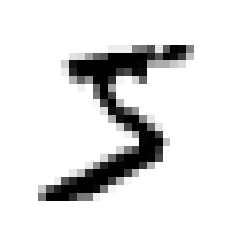

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]
y = y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

In [6]:
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == 5) # true for all 5s, and false for all others
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
	clone_clf = clone(sgd_clf)
	X_train_folds = X_train[train_index]
	y_train_folds = y_train_5[train_index]
	X_test_fold = X_train[test_index]
	y_test_fold = y_train_5[test_index]

	clone_clf.fit(X_train_folds, y_train_folds)
	y_pred = clone_clf.predict(X_test_fold)
	n_correct = sum(y_pred == y_test_fold)
	print(n_correct/len(y_pred))

0.9236
0.9672666666666667
0.9680666666666666
0.969


In [8]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [11]:
len(y_train_pred)
len(y_train_5)

60000

In [12]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [13]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [14]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [15]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

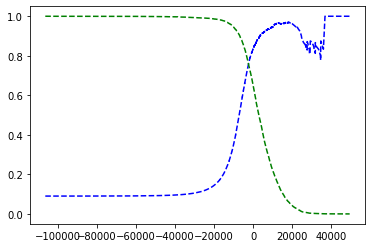

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
	plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
	plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [17]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
print(y_scores > threshold)

threshold = 8000
print(y_scores > threshold)

[2164.22030239]
[ True]
[False]


In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, method="decision_function", cv=3)

In [20]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

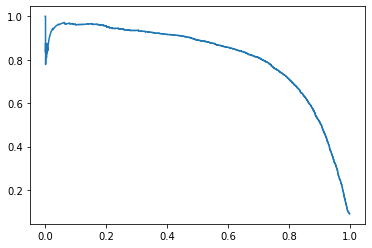

In [21]:
plt.plot(recalls[:-1], precisions[:-1])

In [22]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

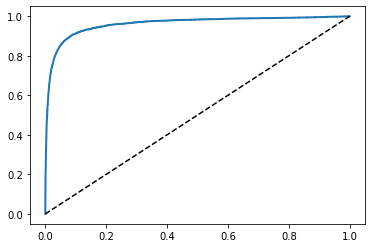

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
	plt.plot(fpr, tpr, linewidth=2, label=label)
	plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

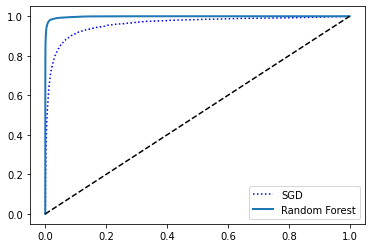

In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

**Multiclass Classification**

In [27]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [33]:
svm_clf.classes_[np.argmax(some_digit_scores)]

5

In [34]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [36]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [39]:
from tune_sklearn import TuneSGDClassifier


ImportError: cannot import name 'TuneSGDClassifier' from 'tune_sklearn' (/Users/ethan/opt/anaconda3/envs/data/lib/python3.9/site-packages/tune_sklearn/__init__.py)

In [40]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=2):
	